In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from bloch.bloch import bloch
import os.path

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [3]:
# Excitation pulse calculation
pf_exc = 'pulses/hsinc_400_8750.hsinc_400_8750.pta'
EXC_AMP_INT = 45.4907  # Manualy coppied from file
pulse_dur_exc = 3.0

pulse_df = pd.read_csv(
    pf_exc,
    sep=r"\s+",
    index_col=False,
    skip_blank_lines=True,
    names=['Amplitude', 'Phase'],
    skiprows=8)

amp_int_rel = EXC_AMP_INT / pulse_df['Amplitude'].size
fa = 90
pulse_length_exc = pulse_dur_exc / 1E3  # In s.
pulse_amp_hz = 500 * (1E-3/pulse_length_exc) * (fa/180) * (1/amp_int_rel)
exc_pulse_hz = pulse_df['Amplitude'].to_numpy()\
    * np.exp(1j * pulse_df['Phase'].to_numpy())
exc_pulse_hz *= pulse_amp_hz
print(pulse_amp_hz)

732.7505035827837


/var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gt/T/ipykernel_63825/2007343371.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  pulse_df = pd.read_csv(


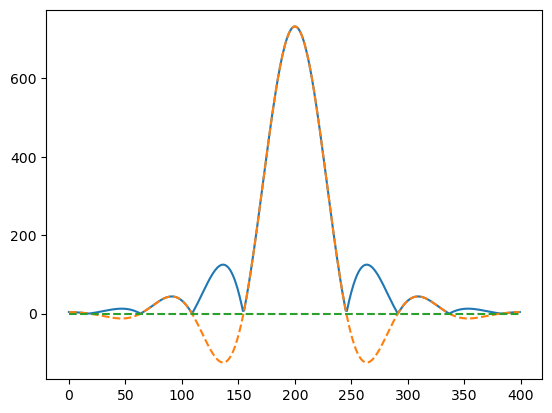

In [4]:
plt.plot(np.abs(exc_pulse_hz))
plt.plot(exc_pulse_hz.real,'--')
plt.plot(exc_pulse_hz.imag,'--')

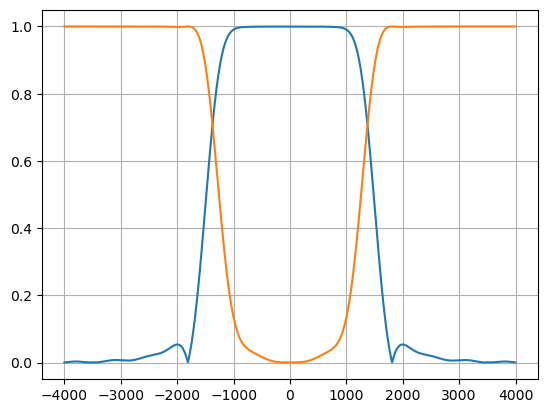

In [5]:
g = np.zeros(exc_pulse_hz.shape)

dt = (pulse_dur_exc / 1E3) / exc_pulse_hz.size
t1 = 5.0
t2 = 5.0
dp = 0
df = np.arange(-4000,4000,5, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(exc_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
plt.grid()
plt.show()

## Editing pulse

In [6]:
# Editing pulse calculation
pulse_df = pd.read_csv(
    'pulses/SLR25600.INR5_OUTR1.pta',
    sep=r"\s+",
    index_col=False,
    skip_blank_lines=True,
    names=['Amplitude', 'Phase'],
    skiprows=8)

EDIT_AMP_INT = 277.145997509 
pulse_dur_edit = 11.776
amp_int_rel = EDIT_AMP_INT / pulse_df['Amplitude'].size
fa = 180
pulse_length_edit = pulse_dur_edit / 1E3  # In s.
pulse_amp_hz = 500 * (1E-3/pulse_length_edit) * (fa/180) * (1/amp_int_rel)
editing_pulse_hz = pulse_df['Amplitude'].to_numpy()\
    * np.exp(1j * pulse_df['Phase'].to_numpy())
editing_pulse_hz *= pulse_amp_hz


/var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gt/T/ipykernel_63825/2526072001.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  pulse_df = pd.read_csv(


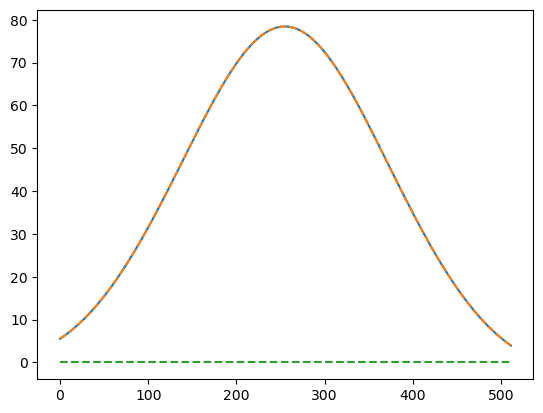

In [9]:
plt.plot(np.abs(editing_pulse_hz))
plt.plot(editing_pulse_hz.real,'--')
plt.plot(editing_pulse_hz.imag,'--')

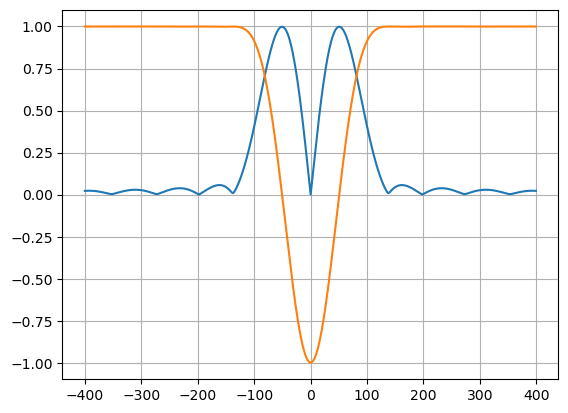

In [12]:
g = np.zeros(editing_pulse_hz.shape)

dt = (pulse_dur_edit / 1E3) / editing_pulse_hz.size
t1 = 5.0
t2 = 5.0
dp = 0
df = np.arange(-400,400,1, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(editing_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
plt.grid()
plt.show()

## Refocussing pulse

In [28]:
def hsn_cmrr(t, n, r=None, target_bw=None, plot=False):
    if r is None and target_bw is None:
        raise ValueError('Specify one of R or target BW')
    
    pulse_dur_ref = t * 1E-3
    if r is None:
        r = target_bw * pulse_dur_ref
    print(f'Calculating HS{n}, R = {r}, Tp = {t} ms')

    ref_points = 400
    taxis = np.linspace(0, pulse_dur_ref, ref_points)

    tau = 1 - (2 * taxis / pulse_dur_ref)
    beta = 5.299
    bw = r / pulse_dur_ref
    amp = 1 / np.cosh(beta * (tau ** n))
    fm = bw * (1 - 2 * (np.cumsum(amp**2)/ np.sum(amp**2)))
    pm = 2 * np.pi * np.cumsum(fm) * taxis[1]

    if plot:
        plt.plot(taxis,amp)
        plt.plot(taxis,fm/bw)
        plt.show()
        plt.plot(taxis,pm)
        plt.show()

    area = np.trapz(np.abs(amp)) / len(taxis)
    sar = np.trapz(np.abs(amp)**2) / len(taxis)
    print(f'Pulse area (% RECT): {100 * area:0.1f}')
    print(f'Pulse relative SAR: {100 * sar:0.1f}')

    return amp * np.exp(1j*pm), taxis[1]

In [34]:
ref_pulse_cmplx, tstep= hsn_cmrr(8.5, 3, r=None, target_bw=3000, plot=False)
ref_pulse_cmplx, tstep= hsn_cmrr(8.5, 1, r=None, target_bw=2350, plot=False)


Calculating HS3, R = 25.500000000000004, Tp = 8.5 ms
Pulse area (% RECT): 63.1
Pulse relative SAR: 54.7
Calculating HS1, R = 19.975, Tp = 8.5 ms
Pulse area (% RECT): 29.4
Pulse relative SAR: 18.8


Calculating HS3, R = 25.500000000000004, Tp = 8.5 ms


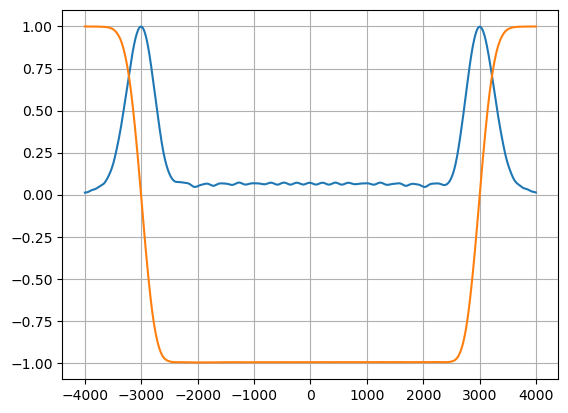

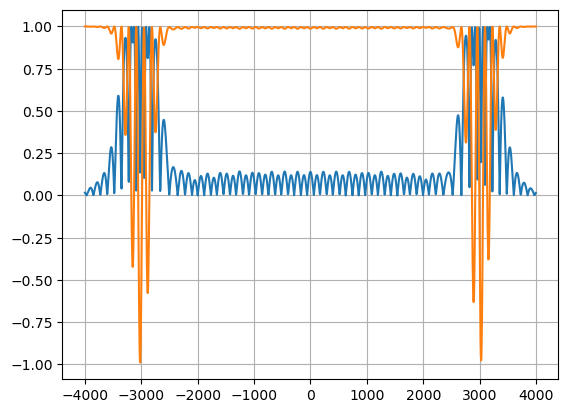

0.9923610012281037


In [14]:
ref_pulse_cmplx, tstep= hsn_cmrr(8.5, 3, r=None, target_bw=3000, plot=False)

fixed_v = 512
true_ref = 285
ref_pulse_hz = ref_pulse_cmplx * 500 * 538/285

g = np.zeros(ref_pulse_hz.shape)

dt = tstep
t1 = 5.0
t2 = 5.0
dp = 0
df = np.arange(-4000,4000,5, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(ref_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
# plt.plot(df,np.angle(mx+1j*my)/np.pi,'k:')
plt.grid()
plt.show()
for idx in range(1):
    mx, my, mz = bloch(ref_pulse_hz, g, dt, t1, t2, df, dp, mode, mx, my, mz)

plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
# plt.plot(df,np.angle(mx+1j*my)/np.pi,'k:')
plt.grid()
plt.show()

print(mz[(df < 1000) & (df > -1000)].mean())

In [35]:
# Adiabatic limit
B1_hz_vec = np.arange(100,2000,25)
df = np.arange(-3000,3000,10, dtype=float)

n_val = np.arange(1,9)
mxy_store_dur = []
mz_store_dur = []
for nv in n_val :
    ref_pulse_cmplx, dt2= hsn_cmrr(8.5, nv, r=None, target_bw=2350, plot=False)
    ref_pulse_hz = ref_pulse_cmplx * 500 * 538/285
    mxy_store = []
    mz_store = []
    for b1 in B1_hz_vec:
        ref_pulse_hz = ref_pulse_cmplx * b1
        mx, my, mz = bloch(ref_pulse_hz, g, dt2, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)
        mxy_store.append(np.abs(mx+1j*my))
        mz_store.append(mz)

    mxy_store_dur.append(np.concatenate(mxy_store,axis=1))
    mz_store_dur.append(np.concatenate(mz_store,axis=1))

mxy_store_dur = np.asarray(mxy_store_dur)
mz_store_dur = np.asarray(mz_store_dur)

Calculating HS1, R = 19.975, Tp = 8.5 ms
Pulse area (% RECT): 29.4
Pulse relative SAR: 18.8
Calculating HS2, R = 19.975, Tp = 8.5 ms
Pulse area (% RECT): 51.2
Pulse relative SAR: 41.3
Calculating HS3, R = 19.975, Tp = 8.5 ms
Pulse area (% RECT): 63.1
Pulse relative SAR: 54.7
Calculating HS4, R = 19.975, Tp = 8.5 ms
Pulse area (% RECT): 70.4
Pulse relative SAR: 63.3
Calculating HS5, R = 19.975, Tp = 8.5 ms
Pulse area (% RECT): 75.3
Pulse relative SAR: 69.2
Calculating HS6, R = 19.975, Tp = 8.5 ms
Pulse area (% RECT): 78.8
Pulse relative SAR: 73.4
Calculating HS7, R = 19.975, Tp = 8.5 ms
Pulse area (% RECT): 81.4
Pulse relative SAR: 76.7
Calculating HS8, R = 19.975, Tp = 8.5 ms
Pulse area (% RECT): 83.4
Pulse relative SAR: 79.2


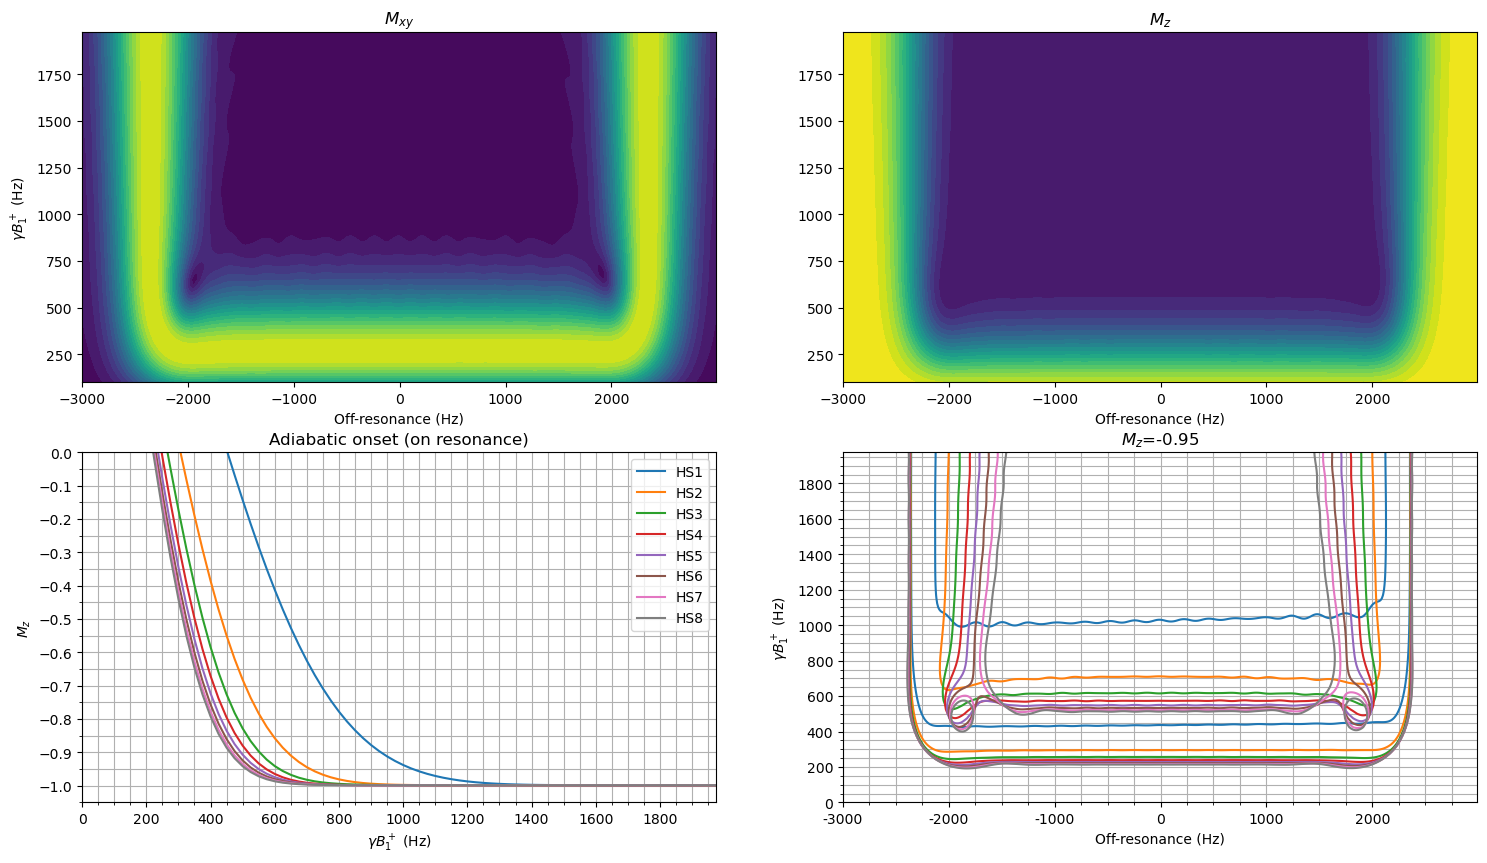

In [36]:
fig, ax = plt.subplots(2,2,figsize=(18,10),sharey=False)
ax[0][0].contourf(df,B1_hz_vec,mxy_store_dur[2].T, levels= np.arange(0,1.1,0.05))
ax[0][1].contourf(df,B1_hz_vec,mz_store_dur[2].T, levels= np.arange(-1.1,1.1,0.10))

lineObjects = ax[1][0].plot(B1_hz_vec, mz_store_dur[:,int(df.size/2),:].squeeze().T)
ax[1][0].legend(lineObjects, [f'HS{x}' for x in n_val])

for mz, lo in zip(mz_store_dur, lineObjects):
    ax[1][1].contour(df,B1_hz_vec,mz.T, levels=(-0.95, 0.05), colors=lo.get_color(), linestyles='solid')


ax[0][0].set_ylabel('$\gamma B_1^+$ (Hz)')
ax[0][0].set_xlabel('Off-resonance (Hz)')
ax[0][1].set_xlabel('Off-resonance (Hz)')
ax[0][0].set_title('$M_{xy}$')
ax[0][1].set_title('$M_{z}$')

ax[1][0].set_xlim([0, B1_hz_vec.max()])
ax[1][0].set_ylim([-1.05, 0])
ax[1][0].set_xlabel('$\gamma B_1^+$ (Hz)')
ax[1][0].set_ylabel('$M_{z}$')

ax[1][0].xaxis.set_major_locator(MultipleLocator(200))
ax[1][0].xaxis.set_major_formatter('{x:.0f}')
# For the minor ticks, use no labels; default NullFormatter.
ax[1][0].xaxis.set_minor_locator(MultipleLocator(50))
ax[1][0].yaxis.set_major_locator(MultipleLocator(0.1))
# ax[1][0].yaxis.set_major_formatter('{x:.0f}')
ax[1][0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1][0].grid(which='both')

ax[1][1].set_ylim([0, B1_hz_vec.max()])
ax[1][1].xaxis.set_major_locator(MultipleLocator(1000))
ax[1][1].xaxis.set_major_formatter('{x:.0f}')
# For the minor ticks, use no labels; default NullFormatter.
ax[1][1].xaxis.set_minor_locator(MultipleLocator(250))
ax[1][1].yaxis.set_major_locator(MultipleLocator(200))
# ax[1][0].yaxis.set_major_formatter('{x:.0f}')
ax[1][1].yaxis.set_minor_locator(MultipleLocator(50))
ax[1][1].grid(which='both')
ax[1][1].set_ylabel('$\gamma B_1^+$ (Hz)')
ax[1][1].set_xlabel('Off-resonance (Hz)')
ax[1][0].set_title('Adiabatic onset (on resonance)')
ax[1][1].set_title('$M_{z}$=-0.95')
plt.show()

In [41]:

vox_size = 0.02
def_bw = 25 / 8.5E-3
grad_hz_m = def_bw/vox_size
grad_mt_m = grad_hz_m / 42.5E3
print(grad_mt_m)
csda_m_1ppm = 300 / grad_hz_m
csda_cm_1ppm = csda_m_1ppm * 100
print(f'The CSDA is {csda_cm_1ppm:0.3f} (cm per ppm), i.e. {100*csda_cm_1ppm/(vox_size*100):0.1f}% of the {vox_size*100} cm voxel')


3.460207612456747
The CSDA is 0.204 (cm per ppm), i.e. 10.2% of the 2.0 cm voxel


## WS pulse

54.73055159919345


/var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gp/T/ipykernel_32150/3969864150.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  pulse_df = pd.read_csv(


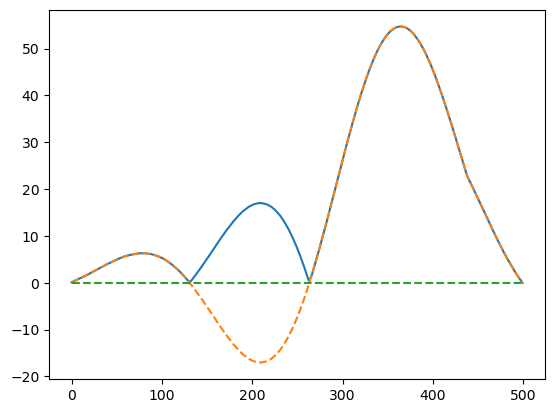

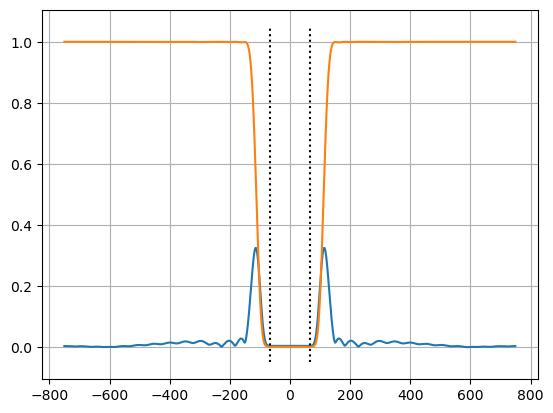

In [15]:
# Excitation pulse calculation
pf_ws = 'pulses/P10.P10TR1_500pts.pta'
WS_AMP_INT = 114.195816  # Manualy coppied from file
pulse_dur_ws = 20

pulse_df = pd.read_csv(
    pf_ws,
    sep=r"\s+",
    index_col=False,
    skip_blank_lines=True,
    names=['Amplitude', 'Phase'],
    skiprows=8)

amp_int_rel = WS_AMP_INT / pulse_df['Amplitude'].size
fa = 90
pulse_length_ws = pulse_dur_ws / 1E3  # In s.
pulse_amp_hz = 500 * (1E-3/pulse_length_ws) * (fa/180) * (1/amp_int_rel)
ws_pulse_hz = pulse_df['Amplitude'].to_numpy()\
    * np.exp(1j * pulse_df['Phase'].to_numpy())
ws_pulse_hz *= pulse_amp_hz
print(pulse_amp_hz)

plt.plot(np.abs(ws_pulse_hz))
plt.plot(ws_pulse_hz.real,'--')
plt.plot(ws_pulse_hz.imag,'--')
plt.show()

g = np.zeros(ws_pulse_hz.shape)

dt = (pulse_dur_ws / 1E3) / ws_pulse_hz.size
t1 = 5.0
t2 = 5.0
dp = 0
df = np.arange(-750,750,1, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(ws_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)
mx, my, mz = bloch(ws_pulse_hz, g, dt, t1, t2, df, dp, mode, 0*mx, 0*my, mz)
mx, my, mz = bloch(ws_pulse_hz, g, dt, t1, t2, df, dp, mode, 0*mx, 0*my, mz)
mx, my, mz = bloch(ws_pulse_hz, g, dt, t1, t2, df, dp, mode, 0*mx, 0*my, mz)

plt.plot(df,np.abs(mx+1j*my))
plt.plot(df,mz)
plt.vlines((-135/2, 135/2), -0.05, 1.05, colors='k', linestyles=':')
plt.grid()
plt.show()